# Which team will win the 2018 FIFA world cup ?

Hello world ! 👋

This year is the year of the FIFA world cup that will take place in Russia from the 14th june to the 15th july. I think it can be fun to try to predict which team will win by using all international football matches and the result.

Also for me I will try to have a better comprehension about the poisson distribution.

So the model that I will build is based on the number of goals scored and conceded by each team, I will also add a weight which depends on the date of the match and the tournament type (Friendly, FIFA World Cup, ...) then we can simulate a match with a goal average for each team and thanks to the matrix I will have, I will find out the probability of a team to win, loose or draw. After that let's simulate the whole tournament ! ⚽

This kernel is inspired from this article : [link](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/).

## Table of content

* [Import librairies](#Import-libraries)
* [Reading the data](#Reading-the-data)
* [Exploratory data analysis and visualizations](#Exploratory-data-analysis-and-visualizations)
    * [What are the most tournament played ?](#What-are-the-most-tournament-played-?)
    * [What are the teams with the best goal average ?](#What-are-the-teams-with-the-best-goal-average-?)
    * [What are the teams who played the most matches ?](#What-are-the-teams-who-played-the-most-matches-?)
    * [What are the teams who scored the most ?](#What-are-the-teams-who-scored-the-most-?)
    * [Poisson distribution for the score (all team)](#Poisson-distribution-for-the-score-(all-team))
    * [Poisson distribution for the score (France and Germany)](#Poisson-distribution-for-the-score-(France-and-Germany))
* [Building the model](#Building-the-model)
* [Simulate the competition](#Simulate-the-competition)


## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
from IPython.display import display, HTML

## Reading the data

In [2]:
matches = pd.read_csv('results.csv')

## Exploratory data analysis and visualizations

In [3]:
matches.head(2)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False


So we can see that each row is composed of :
* a date
* the two teams and their score
* the tournament
* the location : country and city
* if the location is neutral

First I set the type of the date to datetime.

In [4]:
matches = matches.astype({'date':'datetime64[ns]'})

Now let's see which tournament type is the most played.

### What are the most tournament played ?

Text(0.5, 1.0, 'TOP 10 TYPE OF MATCH TOURNAMENTS')

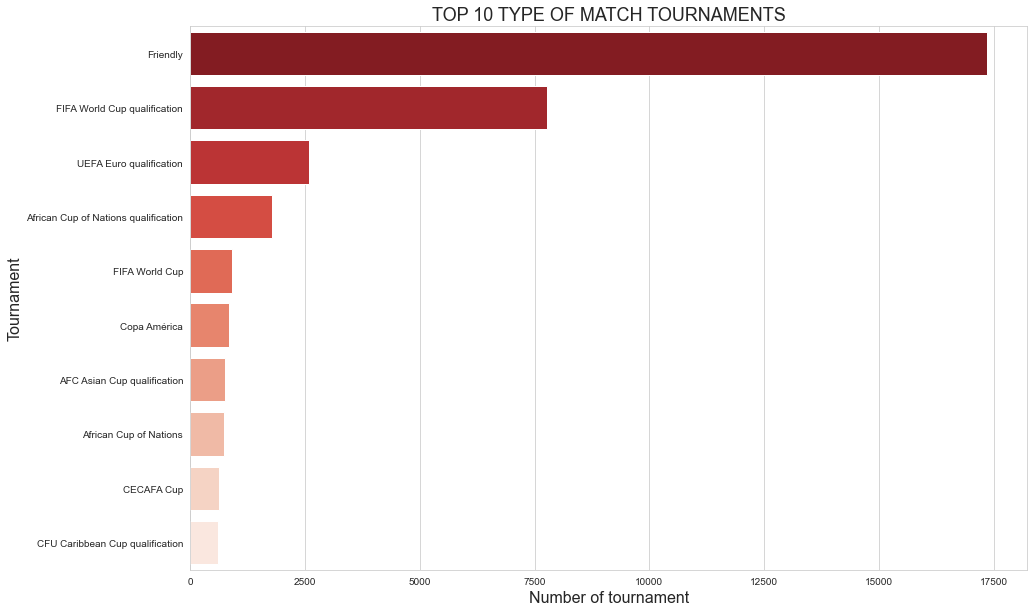

In [5]:
tournament = matches['tournament'].value_counts()
tournament = tournament[:10]

plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=tournament.index, x=tournament.values, palette="Reds_r", orient='h')
ax.set_ylabel('Tournament', size=16)
ax.set_xlabel('Number of tournament', size=16)
ax.set_title("TOP 10 TYPE OF MATCH TOURNAMENTS", fontsize=18)

Then I create a dataframe with some statistics by team like the sum, count and mean of score for each team.

In [6]:
# create two dataframe for the home and away teams
home = matches[['home_team', 'home_score']].rename(columns={'home_team':'team', 'home_score':'score'})
away = matches[['away_team', 'away_score']].rename(columns={'away_team':'team', 'away_score':'score'})
# merge it into one
team_score = home.append(away).reset_index(drop=True)
# make an aggregation of the the score column group by the team
country_info = team_score.groupby('team')['score'].agg(['sum','count','mean']).reset_index()
country_info = country_info.rename(columns={'sum':'nb_goals', 'count':'nb_matches', 'mean':'goal_avg'})

del home, away

Now let's have a look about it with some visualizations.

### What are the teams with the best goal average ?

Text(0.5, 1.0, 'TOP 10 OF GOAL AVERAGE PER MATCH')

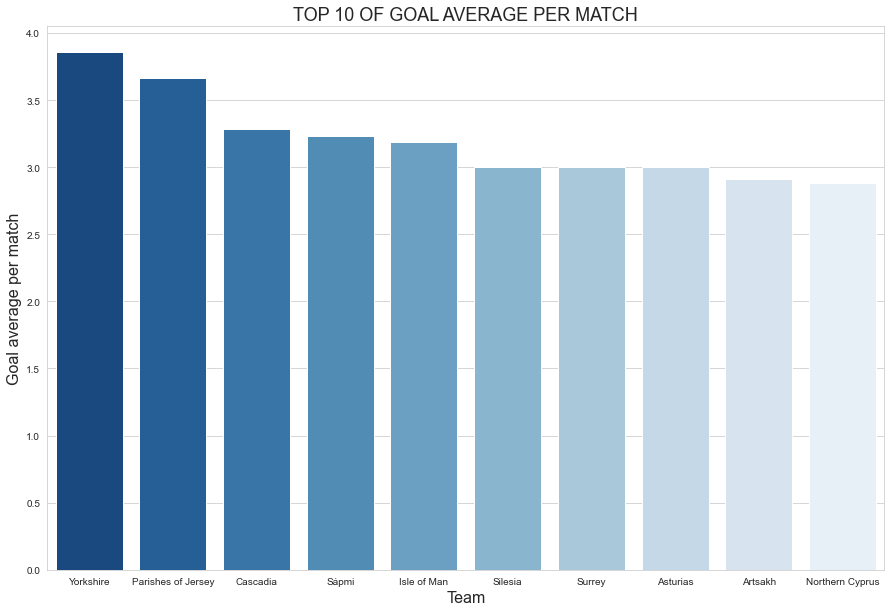

In [7]:
plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
plt_data = country_info.sort_values(by='goal_avg', ascending=False)[:10]
ax = sns.barplot(x="team", y="goal_avg", data=plt_data, palette="Blues_r")
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Goal average per match', size=16)
ax.set_title("TOP 10 OF GOAL AVERAGE PER MATCH", fontsize=18)

### What are the teams who played the most matches ?

Text(0.5, 1.0, 'TOP 10 OF NUMBER OF MATCHES')

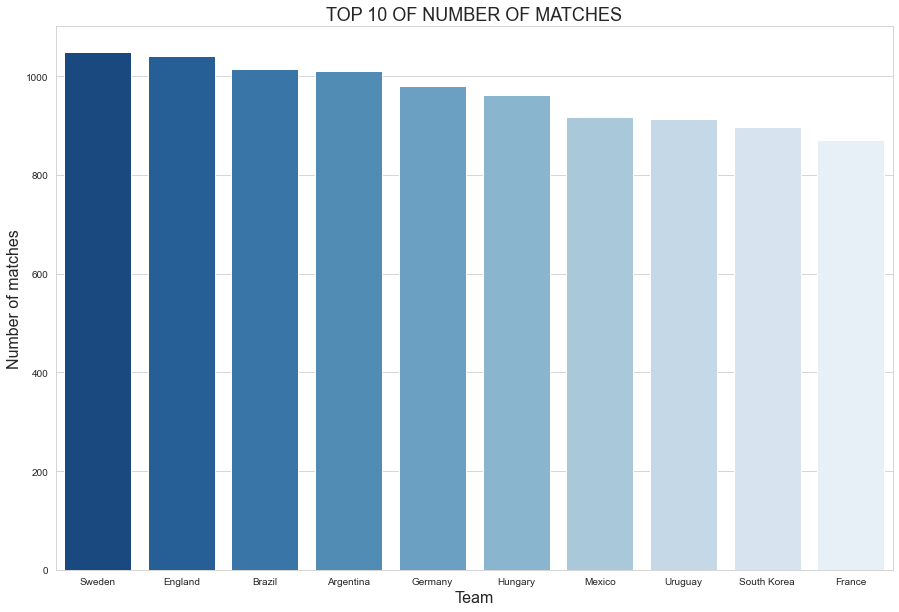

In [8]:
plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
plt_data = country_info.sort_values(by='nb_matches', ascending=False)[:10]
ax = sns.barplot(x="team", y="nb_matches", data=plt_data, palette="Blues_r")
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Number of matches', size=16)
ax.set_title("TOP 10 OF NUMBER OF MATCHES", fontsize=18)

### What are the teams who scored the most ?

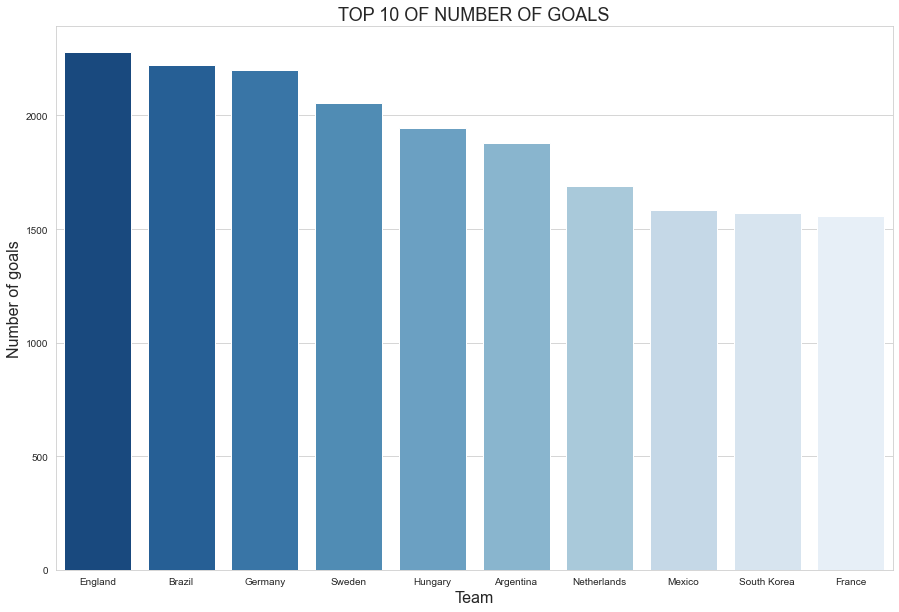

In [9]:
plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
plt_data = country_info.sort_values(by='nb_goals', ascending=False)[:10]
ax = sns.barplot(x="team", y="nb_goals", data=plt_data, palette="Blues_r")
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Number of goals', size=16)
ax.set_title("TOP 10 OF NUMBER OF GOALS", fontsize=18)

del plt_data, country_info

In [10]:
means = matches[['home_score','away_score']].mean()
means

home_score    1.740126
away_score    1.180129
dtype: float64

We can notice that, on average, the home team scored more goals than the away team. So now it's time to introduce the Poisson distribution : it's a discrete probability distribution (it provides the probabilities of occurrence of different possible outcomes in an event) that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant rate and independently of the time since the last event (Wikipedia definition).

An important assumption is that each events are independent in time. Here, it means that goals don't become more or less likely by the number of goals that is already scored in a match. We can formulate this by the probability mass function : 

$$
P(x) = \frac{{e}^{-\lambda}{\lambda}^{x}}{x!}, \lambda > 0
$$

$\lambda$ represents the average rate. So now we can visualisate it for all the match and for two differents teams.

 ### Poisson distribution for the score (all team)

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of ticklabels (11).

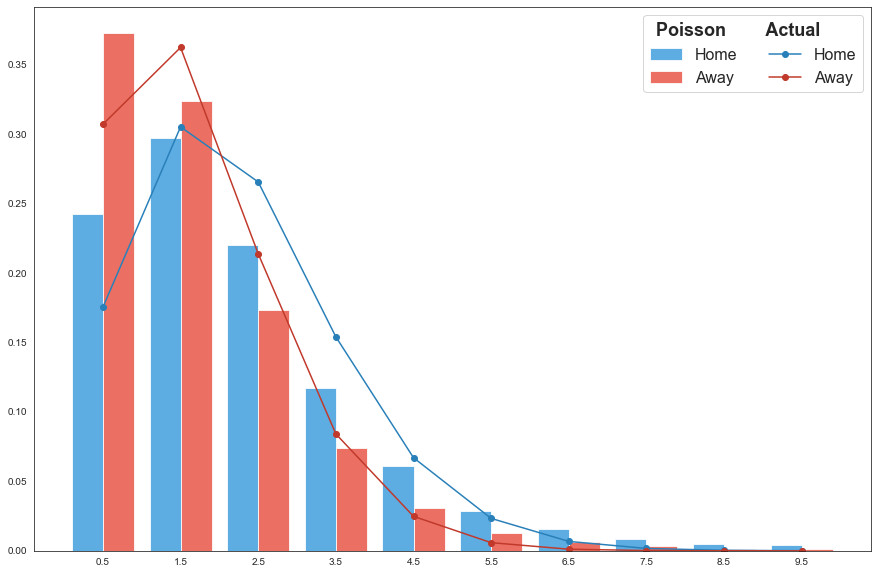

In [12]:
plt.figure(figsize=(15,10))
sns.set_style("white")
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(k, means[j]) for k in range(10)] for j in range(2)])
# plot histogram of actual goals
plt.hist(matches[['home_score', 'away_score']].values, range(11), alpha=0.8,
         label=['Home', 'Away'],density=True, color=["#3498db", "#e74c3c"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#2980b9')
pois2, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#c0392b')

leg=plt.legend(loc='upper right', fontsize=16, ncol=2)
leg.set_title("Poisson        Actual      ", prop = {'size':'18', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,11)],[i for i in range(11)])
plt.xlabel("Goals per Match",size=18)
plt.ylabel("Proportion of Matches",size=18)
plt.title("Number of Goals per Match",size=20,fontweight='bold')
plt.show()

 ### Poisson distribution for the score (France and Germany)

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of ticklabels (11).

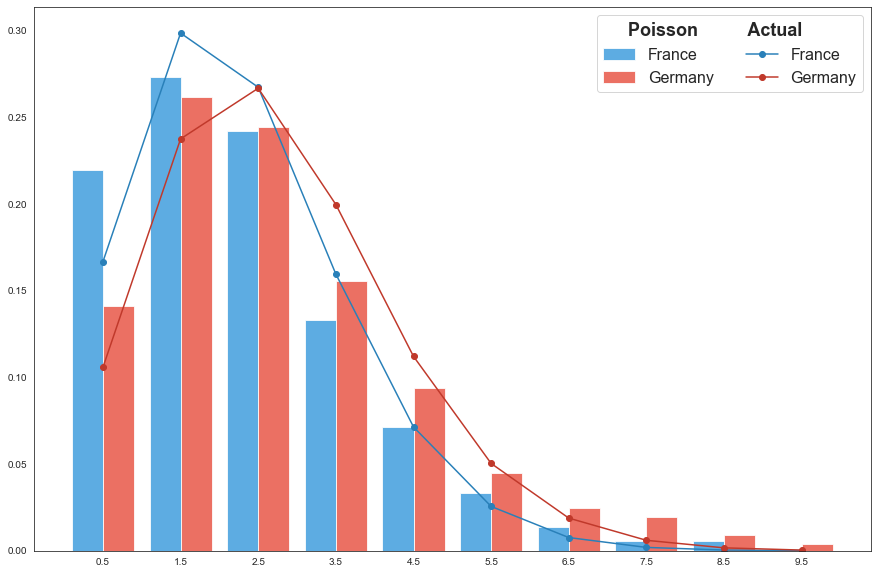

In [14]:
plt.figure(figsize=(15,10))
sns.set_style("white")
team1, team2 = "France", "Germany"
matches_t1 = team_score[team_score['team'] == team1]
matches_t2 = team_score[team_score['team'] == team2]
    
mean_t1 = matches_t1['score'].mean()
mean_t2 = matches_t2['score'].mean()

# construct Poisson  for each mean goals value
poisson_pred_t1 = [poisson.pmf(k, mean_t1) for k in range(10)]
poisson_pred_t2 = [poisson.pmf(k, mean_t2) for k in range(10)]

# plot histogram of actual goals
plt.hist([matches_t1['score'].values, matches_t2['score'].values], range(11), alpha=0.8,
         label=[team1, team2],density=True, color=["#3498db", "#e74c3c"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred_t1,
                  linestyle='-', marker='o',label=team1, color = '#2980b9')
pois2, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred_t2,
                  linestyle='-', marker='o',label=team2, color = '#c0392b')

leg=plt.legend(loc='upper right', fontsize=16, ncol=2)
leg.set_title("Poisson          Actual      ", prop = {'size':'18', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,11)],[i for i in range(11)])
plt.xlabel("Goals per Match",size=18)
plt.ylabel("Proportion of Matches",size=18)
plt.title("Number of Goals per Match",size=20,fontweight='bold')
plt.show()

## Building the model

Now we can agree to say that each team follow the Poisson distribution due to the number of game. So first I will add a weight column that is based on the date of the game because it's obvious that a game that took place this year has more weight than the first game in 1872.

Then I create the data for the model which is composed of 4 columns : team, opponent, goals and weight.

In [22]:
def weight_from_tournament(tournament):
    if 'Cup' in tournament or 'Euro' in tournament:
        return 1
    else :
        return 100

# Create weight column based on the date
matches.loc[:,'weight'] = matches['tournament'].apply(weight_from_tournament)
matches.loc[:,'weight'] = 1 / ((2019 - matches['date'].dt.year.astype('int64'))*matches['weight'])

# Create model data
matches_model_data = pd.concat([matches[['home_team','away_team','home_score','weight']].rename(
            columns={'home_team':'team', 'away_team':'opponent','home_score':'goals'}),
           matches[['away_team','home_team','away_score','weight']].rename(
            columns={'away_team':'team', 'home_team':'opponent','away_score':'goals'})])

In [67]:
matches_model_data

,team,opponent,goals,weight
0,Scotland,England,0,0.000068
1,England,Scotland,4,0.000068
2,Scotland,England,2,0.000069
3,England,Scotland,2,0.000069
4,Scotland,England,3,0.000070
...,...,...,...,...
43747,Andorra,Moldova,1,-0.003333
43748,Latvia,Liechtenstein,2,-0.003333
43749,Ghana,Chile,0,-0.333333
43750,Tunisia,Japan,3,-0.333333


So here using the statsmodels librairies I create my model with a Poisson regression.

In [33]:
matches_model_data['weight'].isnull().sum()

0

In [46]:
from sklearn import linear_model
clf = linear_model.PoissonRegressor()

In [ ]:
X = [[1, 2], [2, 3], [3, 4], [4, 3]]
y = [12, 17, 22, 21]
clf.fit(X, y)
clf.score(X, y)
clf.coef_
clf.intercept_
clf.predict([[1, 1], [3, 4]])

In [49]:
weighted = matches_model_data['weight'].values

In [60]:
weights = np.interp(weighted, (weighted.min(), weighted.max()), (-1, +1))

In [63]:
poisson_model = smf.glm(formula="goals ~ team + opponent", 
                        data=matches_model_data, 
                        family=sm.families.Poisson(), 
                        mu=weights).fit()

/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['mu']
  warnings.warn(msg, ValueWarning)


Now it's time to make a function that can return the result of a game, there is some information that we need to know :
* The two teams
* If the match is a elimination or not (if True we can't return a draw result)
* The maximum of draw which will indicate how many draw we will do for the game. The greater this number is, the result will mostly be the result with the greatest probability.
* The maximum goals in the game

So first I define the function that will a tuple of two array : 
* An array with the 3 probabilites of the team 1 to win, a draw game and the team 2 to win.
* An array with the probabilities of score for each team

In [64]:
def get_proba_match(foot_model, team1, team2, max_goals=10):
    # Get the average goal for each team
    t1_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team1, 'opponent': team2}, index=[1])).values[0]
    t2_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team2, 'opponent': team1}, index=[1])).values[0]
    
    # Get probability of all possible score for each team
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [t1_goals_avg, t2_goals_avg]]
    
    # Do the product of the 2 vectors to get the matrix of the match
    match = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    
    # Get the proba for each possible outcome
    t1_wins = np.sum(np.tril(match, -1))
    draw = np.sum(np.diag(match))
    t2_wins = np.sum(np.triu(match, 1))
    result_proba = [t1_wins, draw, t2_wins]
    
    # Adjust the proba to sum to one
    result_proba =  np.array(result_proba)/ np.array(result_proba).sum(axis=0,keepdims=1)
    team_pred[0] = np.array(team_pred[0])/np.array(team_pred[0]).sum(axis=0,keepdims=1)
    team_pred[1] = np.array(team_pred[1])/np.array(team_pred[1]).sum(axis=0,keepdims=1)
    return result_proba, [np.array(team_pred[0]), np.array(team_pred[1])]

Now I can do the function that will get us the result of the game. It will return the result first (the winner or draw), the looser (it will be 'draw' if it's a draw result) and the score of each team.

In [65]:
def get_match_result(foot_model, team1, team2, elimination=False, max_draw=50, max_goals=10):
    # Get the proba
    proba, score_proba = get_proba_match(foot_model, team1, team2, max_goals)
    
    # Get the result, if it's an elimination game we have to be sure the result is not draw
    results = pd.Series([np.random.choice([team1, 'draw', team2], p=proba) for i in range(0,max_draw)]).value_counts()
    result = results.index[0] if not elimination or (elimination and results.index[0] != 'draw') else results.index[1]
    
    # If the result is not a draw game then we calculate the score of the winner from 1 to the max_goals 
    # and the score of the looser from 0 to the score of the winner
    if (result != 'draw'): 
        i_win, i_loose = (0,1) if result == team1 else (1,0)
        score_proba[i_win] = score_proba[i_win][1:]/score_proba[i_win][1:].sum(axis=0,keepdims=1)
        winner_score = pd.Series([np.random.choice(range(1, max_goals+1), p=score_proba[i_win]) for i in range(0,max_draw)]).value_counts().index[0]
        score_proba[i_loose] = score_proba[i_loose][:winner_score]/score_proba[i_loose][:winner_score].sum(axis=0,keepdims=1)
        looser_score = pd.Series([np.random.choice(range(0, winner_score), p=score_proba[i_loose]) for i in range(0,max_draw)]).value_counts().index[0]
        score = [winner_score, looser_score]
    # If it's a draw then we calculate a score and repeat it twice
    else:
        score = np.repeat(pd.Series([np.random.choice(range(0, max_goals+1), p=score_proba[0]) for i in range(0,max_draw)]).value_counts().index[0],2)
    looser = team2 if result == team1 else team1 if result != 'draw' else 'draw'
    return result, looser, score

Now let's try it !

In [66]:
print(get_match_result(poisson_model, 'Gabon', 'Togo'))
print(get_match_result(poisson_model, 'France', 'Togo', elimination=True))
print(get_match_result(poisson_model, 'Argentina', 'Germany'))
print(get_match_result(poisson_model, 'Brazil', 'Vatican', max_goals=20))
print(get_match_result(poisson_model, 'England', 'Morocco'))
print(get_match_result(poisson_model, 'Iran', 'Japan'))

('Gabon', 'Togo', [1, 0])
('France', 'Togo', [2, 0])
('Argentina', 'Germany', [1, 0])


PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 'Vatican' does not match any of the expected levels (expected: ['Abkhazia', 'Afghanistan', ..., 'Zimbabwe', 'Åland Islands'])
    goals ~ team + opponent
                   ^^^^^^^^

## Simulate the competition

It's time to do the competition !  First let's create the groups following the image below :

![](https://i.redd.it/u20bx17v2c101.jpg)

In [54]:
groupA = ['Qatar', 'Ecuador', 'Senegal', 'Netherlands']
groupB = ['England', 'Iran', 'USA', 'Wales']
groupC = ['Argentina', 'Saudi Arabia', 'Mexico', 'Poland']
groupD = ['France', 'Denmark', 'Tunisia', 'Australia']
groupE = ['Spain', 'Germany', 'Japan', 'Costa Rica']
groupF = ['Belium', 'Canada', 'Morocco', 'Croatia']
groupG = ['Brazil', 'Serbia', 'Switzerland', 'Cameroon']
groupH = ['Portugal', 'Ghana', 'Uruguay', 'Korea Republic']
groups = [groupA, groupB, groupC, groupD, groupE, groupF, groupG, groupH]

Now I create 2 functions : one for the group result and the other for the final result.

In [55]:
def get_group_result(foot_model, group):
    ranking = pd.DataFrame({'points':[0,0,0,0], 'diff':[0,0,0,0], 'goals':[0,0,0,0]}, index=group)
    for team1, team2 in itertools.combinations(group, 2):
        result, looser, score = get_match_result(foot_model, team1, team2)
        #print(result, '-', looser,':', score)
        if result == 'draw':
            ranking.loc[[team1, team2], 'points'] += 1
            ranking.loc[[team1, team2], 'goals'] += score[0]
        else:
            ranking.loc[result, 'points'] += 3
            ranking.loc[result, 'goals'] += score[0]
            ranking.loc[looser, 'goals'] += score[1]
            ranking.loc[result, 'diff'] += score[0]-score[1]
            ranking.loc[looser, 'diff'] -= score[0]-score[1]
            
    return ranking.sort_values(by=['points','diff','goals'], ascending=False)

def get_final_result(foot_model, groups_result):
    round_of_16 = []
    quarter_finals = []
    semi_finals = []
    
    # SIMULATE ROUND OF 16
    for i in range(0, 8, 2):
        round_of_16.append(get_match_result(foot_model, groups_result[i].index[0], groups_result[i+1].index[1], elimination=True))
        round_of_16.append(get_match_result(foot_model, groups_result[i].index[1], groups_result[i+1].index[0], elimination=True))
    
    # SIMULATE QUATER FINALS
    quarter_finals.append(get_match_result(foot_model, round_of_16[0][0], round_of_16[2][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[1][0], round_of_16[3][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[4][0], round_of_16[6][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[5][0], round_of_16[7][0], elimination=True))
    
    # SIMULATE SEMI FINALS
    semi_finals.append(get_match_result(foot_model, quarter_finals[0][0], quarter_finals[2][0], elimination=True))
    semi_finals.append(get_match_result(foot_model, quarter_finals[1][0], quarter_finals[3][0], elimination=True))
    
    # SIMULATE 3RD PLACE MATCH
    little_final = get_match_result(foot_model, semi_finals[0][1], semi_finals[1][1], elimination=True)
    
    # SIMULATE FINAL
    final = get_match_result(foot_model, semi_finals[0][0], semi_finals[1][0], elimination=True)
    
    return round_of_16, quarter_finals, semi_finals, little_final, final

And just like that 4 lines will get us the whole result of the competition !

In [56]:
groups_ranking = []
for group in groups:
    groups_ranking.append(get_group_result(poisson_model, group))

round_of_16, quarter_finals, semi_finals, 
little_final, final = get_final_result(poisson_model, groups_ranking)

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 'USA' does not match any of the expected levels (expected: ['Abkhazia', 'Afghanistan', ..., 'Zimbabwe', 'Åland Islands'])
    goals ~ team + opponent
                   ^^^^^^^^

Let's visualizate the competition result. First we take a look on the groups result with the differents ranking.

In [57]:
for group_rank in groups_ranking:
    display(group_rank)

,points,diff,goals
Netherlands,9,6,6
Senegal,6,0,2
Ecuador,3,-1,2
Qatar,0,-5,0


We can now make the final result in an amazing plot :

In [58]:
plt.figure(figsize = (25,14))
img = mpimg.imread('../input/images/fifa-world-cup.png')
plt.imshow(img)
plt.axis('off')

def text_match(x, y, match, final=False):
    col_win, col_loose = ('green', 'red') if (not final) else ('gold', 'silver')
    plt.text(x, y, match[0], fontsize=12, color=col_win, weight='bold')
    plt.text(x+100, y+1, match[2][0], fontsize=18, color=col_win, weight='bold')
    plt.text(x, y+50, match[1], fontsize=12, color=col_loose, weight='bold')
    plt.text(x+100, y+51, match[2][1], fontsize=18, color=col_loose, weight='bold')


round_of_16_xy = [(40,110),(898,110),(40,280),(898,280),(40,430),(898,430),(40,600),(898,600)]
quarter_finals_xy = [(212,198),(726,198),(212,518),(726,518)]
semi_finals_xy = [(378,365),(560,365)]
x_little_final, y_little_final = 560, 576
x_final, y_final = 469, 157

for (x, y), match in zip(round_of_16_xy, round_of_16):
    text_match(x, y, match)
for (x, y), match in zip(quarter_finals_xy, quarter_finals):
    text_match(x, y, match)
for (x, y), match in zip(semi_finals_xy, semi_finals):
    text_match(x, y, match)
text_match(x_little_final, y_little_final, little_final)
text_match(x_final, y_final, final, final=True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../input/images/fifa-world-cup.png'

<Figure size 1800x1008 with 0 Axes>

Thanks for reading, I know this model is not really accurate but I enjoyed playing with Poisson distribution.

If you have any comments I will be glad to hear it.  👍